# Live trade list quick PnL

Fill the variables below, then run.

rows: 38
portfolio_return: 0.004703799241379004
return stats:
count    38.000000
mean      0.004704
std       0.021168
min      -0.022161
25%      -0.002429
50%      -0.000464
75%       0.002386
max       0.098550
Name: return, dtype: float64


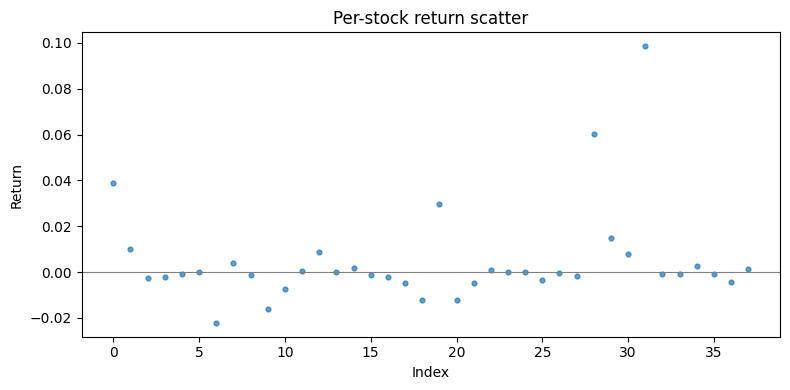

,code,weight,return
0,110074.SH,0.026316,0.038780
1,110076.SH,0.026316,0.010064
2,110085.SH,0.026316,-0.002487
3,111001.SH,0.026316,-0.002051
4,111009.SH,0.026316,-0.000836


In [28]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# ---- settings ----
trade_day = '2026-01-15'  # trade_list date
signal_name = 'combo_default'
batch_id = 'Live'
results_root = Path('D:/cbond_daily/results')
cleaned_root = Path('D:/cbond_daily/clean_data')

buy_twap_col = 'twap_0945_1000'
sell_twap_col = 'twap_1430_1442'
twap_bps = 1.5
fee_bps = 0.7

# ---- load trade list ----
trade_dir = results_root / 'live' / trade_day / batch_id / signal_name
trade_path = trade_dir / 'trade_list.csv'
trades = pd.read_csv(trade_path)
trades['trade_date'] = pd.to_datetime(trades['trade_date']).dt.date

# ---- load cleaned data for trade_day ----
day = pd.to_datetime(trade_day).date()
month = f'{day.year:04d}-{day.month:02d}'
cleaned_path = cleaned_root / month / f'{day:%Y%m%d}.parquet'
df = pd.read_parquet(cleaned_path)

# ---- merge and compute return ----
merged = trades.merge(df[['code', buy_twap_col, sell_twap_col]], on='code', how='left')

def apply_bps(px, bps, side):
    if side == 'buy':
        return px * (1 + bps / 10000.0)
    return px * (1 - bps / 10000.0)

cost_bps = twap_bps + fee_bps
buy_px = apply_bps(merged[buy_twap_col], cost_bps, 'buy')
sell_px = apply_bps(merged[sell_twap_col], cost_bps, 'sell')
merged['return'] = (sell_px - buy_px) / buy_px

# ---- summary ----
merged['weight'] = merged.get('weight', 1.0 / len(merged))
merged['weight'] = merged['weight'].fillna(0.0)
port_ret = float((merged['return'] * merged['weight']).sum())
print('rows:', len(merged))
print('portfolio_return:', port_ret)

# ---- per-stock stats ----
stats = merged['return'].describe()
print('return stats:')
print(stats)

# ---- scatter plot ----
plt.figure(figsize=(8, 4))
plt.scatter(range(len(merged)), merged['return'], s=12, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.8)
plt.title('Per-stock return scatter')
plt.xlabel('Index')
plt.ylabel('Return')
plt.tight_layout()
plt.show()
merged[['code', 'weight', 'return']].head()


In [29]:
merged

,trade_date,code,weight,twap_0945_1000,twap_1430_1442,return
0,2026-01-15,110074.SH,0.026316,488.8498,508.0308,0.038780
1,2026-01-15,110076.SH,0.026316,119.7680,121.0266,0.010064
2,2026-01-15,110085.SH,0.026316,122.8593,122.6077,-0.002487
3,2026-01-15,111001.SH,0.026316,129.8153,129.6060,-0.002051
4,2026-01-15,111009.SH,0.026316,122.6111,122.5625,-0.000836
5,2026-01-15,111014.SH,0.026316,125.5402,125.6120,0.000132
6,2026-01-15,111023.SH,0.026316,182.6835,178.7136,-0.022161
7,2026-01-15,113049.SH,0.026316,116.6550,117.1517,0.003816
8,2026-01-15,113059.SH,0.026316,122.8687,122.7917,-0.001066
9,2026-01-15,113575.SH,0.026316,255.0953,251.1137,-0.016041
